# MADGICX's standard adset performance evalution

__Diagram of the ad set__ [win lose evaluation flow](https://app.diagrams.net/#G1GMSCJ_EQPm-NUYhxQVNe7bFD-vVQk46P#%7B%22pageId%22%3A%22VbIS5GhQtAIJzmuHBgNp%22%7D) 

### Check performance metrics above average

* performance metrics:
   * ROAS: Return on Ad Spend = purchase value / spend value
   * CPA : Average cost per action = spend / sum of action seuence counts
   * CVR : Conversion Rate = 100 * number of app-install-- clicks / number of subsequent clicks
   * CTR : Click Through Rate = number of clicks / number of impressions
* plot time series of daily mean of performance metric indicators
* plot time series of daily adsets below and above performance metric average
* break the plots for each top 85% objectives

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('ignore')     #switch betweeb 'default' and 'ignore'
import traceback

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True


## Instantiate Classes

In [2]:
import os
import sys
import numpy as np
from pyspark.sql import functions as F
# import tensorflow_probability as tfp
# import tensorflow as tf

proj_dir = os.path.abspath(os.pardir)
sys.path.insert(1,proj_dir.split('mining/')[0])
# from rezaware.modules.etl.loader import sparkRDBM as db
# from rezaware.modules.etl.loader import sparkFile as file
from mining.modules.budget.optimization import rwAdsDataFile as file

''' restart initiate classes '''
if debug:
    import importlib
    # db = importlib.reload(db)
    file=importlib.reload(file)
    # attr=importlib.reload(attr)

__desc__ = "read and write dataset for MCMC sampling"

clsFile = file.dataWorkLoads(
    desc = "optimizing action_type budgets for an ad",
    f_store_mode='local-fs',
    f_store_root=proj_dir.split('mining/')[0],
    jar_dir=None,
)
# if clsSDB.session:
#     clsSDB._session.stop
print("\n%s class initialization and load complete!" % __desc__)

All functional __PROPATTR__-libraries in OPTIMIZATION-package of BUDGET-module imported successfully!
All functional RWADSDATA-libraries in OPTIMIZATION-package of BUDGET-module imported successfully!
All functional RWADSDATA-libraries in OPTIMIZATION-package of BUDGET-module imported successfully!
All functional APP-libraries in REZAWARE-package of REZAWARE-module imported successfully!
__propAttr__ Class initialization complete
All functional __PROPATTR__-libraries in LOADER-package of ETL-module imported successfully!
All functional SPARKFILE-libraries in LOADER-package of ETL-module imported successfully!
__propAttr__ Class initialization complete
sparkFile Class initialization complete
rwAdsData Class initialization complete

read and write dataset for MCMC sampling class initialization and load complete!


## Load data
Load from file

In [3]:
_fpath = "mining/data/budget/"
_fname = "FullDataset.csv"

__def_date_attr__="updated_time"
__def_realm__='OBJECTIVE'
__def_obj__ = 'OUTCOME_LEADS'

sdf = clsFile.read_realm(
    realm = __def_realm__,
    to_date = None,
    from_date=None,
    fname = _fname,
    fpath = _fpath,
    # **kwargs,
)
print("Loaded %s %d rows" % (_fname, sdf.count()))# sdf.printSchema()


25/03/05 18:56:10 WARN Utils: Your hostname, FarmRaider2 resolves to a loopback address: 127.0.1.1; using 192.168.2.85 instead (on interface enp3s0)
25/03/05 18:56:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/03/05 18:56:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/05 18:56:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/03/05 18:56:52 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[Stage 422:=============================================>           (4 + 1) / 5]

Loaded FullDataset.csv 1777681 rows


## Select metrics grouped by objectives and adsets

In [72]:
metric_sdf_ = sdf.select(F.col('updated_time').alias('date'),
                         F.col('purchase_roas').alias('roas'),
                         F.col('CTR').alias('ctr'),
                         F.col('CPP').alias('cpp'),
                         F.col('CPM').alias('cpm'),
                         F.col('CPC').alias('cpc'),
                         F.col('spend').alias('spend'),
                         F.col('objective'), 
                         F.col('adset_id'))\
                .dropna()\
                .groupBy(F.col('objective'),
                         F.col('date'), F.col('adset_id'))\
                .agg(F.sum('roas').alias('roas_sum'), 
                     F.sum('ctr').alias('ctr_sum'),
                     F.sum('cpp').alias('cpp_sum'),
                     F.sum('cpm').alias('cpm_sum'),
                     F.sum('cpc').alias('cpc_sum'),
                     F.sum('spend').alias('spend_sum'))\
                .orderBy('date', 'objective', ascending=True)

print("Grouped objectives and metric sums resulted in %d rows" % metric_sdf_.count())

[Stage 868:=============================================>           (4 + 1) / 5]

Grouped objectives and metric sums resulted in 49296 rows


## Compute the daily metric averages for each objective 

In [73]:
_daily_mean = metric_sdf_.groupBy(F.col('objective').alias('mean_objective'), 
                               F.col('date').alias('mean_date'))\
                        .agg(F.mean('roas_sum').alias('obj_roas_mean'),
                             F.mean('ctr_sum').alias('obj_ctr_mean'),
                             F.mean('cpp_sum').alias('obj_cpp_mean'),
                             F.mean('cpm_sum').alias('obj_cpm_mean'),
                             F.mean('cpc_sum').alias('obj_cpc_mean'),
                             F.mean('spend_sum').alias('spend_mean'))\
                    .orderBy('mean_date', ascending=True)
print("Computing objective-wise daily metric means resulted in %d rows" % _daily_mean.count())

[Stage 874:=============================================>           (4 + 1) / 5]

Computing objective-wise daily metric means resulted in 201 rows


## Compute the metric deviation from the mean

In [74]:
_dev_sdf = metric_sdf_.join(
    _daily_mean,
    (_daily_mean['mean_objective'] == metric_sdf_['objective']) & \
    (_daily_mean['mean_date'] == metric_sdf_['date']), "inner")\
    .withColumn('obj_roas_diff', F.col('roas_sum')-F.col('obj_roas_mean'))\
    .withColumn('obj_ctr_diff', F.col('ctr_sum')-F.col('obj_ctr_mean'))\
    .withColumn('obj_cpp_diff', F.col('roas_sum')-F.col('obj_roas_mean'))\
    .withColumn('obj_cpm_diff', F.col('cpm_sum')-F.col('obj_cpm_mean'))\
    .withColumn('obj_cpc_diff', F.col('cpc_sum')-F.col('obj_cpc_mean'))\
    .select('objective', 'date', 'adset_id' ,'obj_roas_diff', 'obj_ctr_diff',
            'obj_cpp_diff', 'obj_cpm_diff', 'obj_cpc_diff', 'spend_mean')
print("Computing the deviation from the mean, resulted in %d rows" % _dev_sdf.count())

[Stage 884:=============================================>           (4 + 1) / 5]

Computing the deviation from the mean, resulted in 49296 rows


## Set the objective and metric

Select a specific objective and metric to compute the date to plot

In [75]:
# Run cell to list objectives and metrics
print("Objectives list:\n", 
      ", ".join([x['objective'] for x in _dev_sdf.select('objective').distinct().collect()]))
print("\nMetric list:\n",
      ", ".join([c for c in _dev_sdf.columns if c.find('obj_')==0]))

[Stage 895:=============================================>           (4 + 1) / 5]

Objectives list:
 APP_INSTALLS, POST_ENGAGEMENT, MESSAGES, OUTCOME_AWARENESS, PRODUCT_CATALOG_SALES, LINK_CLICKS, OUTCOME_LEADS, OUTCOME_ENGAGEMENT, LEAD_GENERATION, VIDEO_VIEWS, CONVERSIONS, OUTCOME_SALES

Metric list:
 obj_roas_diff, obj_ctr_diff, obj_cpp_diff, obj_cpm_diff, obj_cpc_diff


In [76]:
_objective = "APP_INSTALLS"
_metric_diff="obj_ctr_diff"

print('objective set to value:', _objective)
print('metric set to column:', _metric_diff.upper())


objective set to value: APP_INSTALLS
metric set to column: OBJ_CTR_DIFF


## Compute above and below performed adset counts

In [77]:
_neg_daily_counts = _dev_sdf.filter((F.col(_metric_diff)<0) & 
                                              (F.col('objective').isin(_objective)))\
                            .groupBy('date').count().orderBy('date')\
                            .withColumnRenamed('count','neg_count')\
                            .withColumnRenamed('date','neg_date')
_pos_daily_counts = _dev_sdf.filter((F.col(_metric_diff)>0) & 
                                              (F.col('objective').isin(_objective)))\
                            .groupBy('date').count().orderBy('date')\
                            .withColumnRenamed('count','pos_count') \
                            .withColumnRenamed('date','pos_date')
# _pos_daily_counts.show(), _neg_daily_counts.show()
counts_sdf = _pos_daily_counts.join(_neg_daily_counts, 
                                    _pos_daily_counts['pos_date']==_neg_daily_counts['neg_date'])\
                            .select('pos_date','pos_count','neg_count')\
                            .withColumnRenamed('pos_date', 'date')
print("read with %d rows to plot" % counts_sdf.count())

read with 24 rows to plot


### Plot the counts

AD SET ABOVE AND BELOW PERFORMED CTR PERFORMANCE
The y-axis shows adset counts grouped by objective, date, and adset id. the implies metric of pos ad sets are those with CTR > daily average CTR and neg implies are thosse with CTR < daily average CTR.



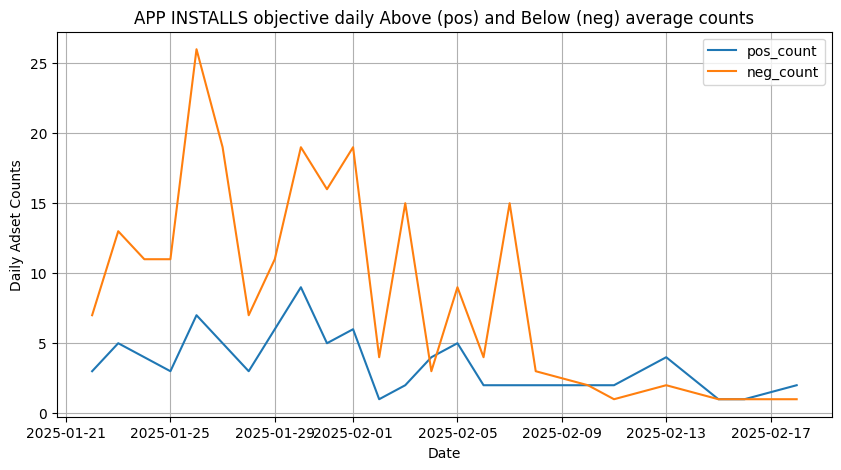

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

counts_df = counts_sdf.toPandas()

print(f"Ad set Above and Below performed {_metric_diff.split('_')[1]} performance".upper()+\
      "\nThe y-axis shows adset counts grouped by objective, date, and adset id. "+\
      f"the implies metric of pos ad sets are those with {_metric_diff.split('_')[1].upper()} > "+\
      f"daily average {_metric_diff.split('_')[1].upper()} and neg implies are thosse with "+\
      f"{_metric_diff.split('_')[1].upper()} < daily average {_metric_diff.split('_')[1].upper()}.\n")

fig, ax = plt.subplots(1, figsize=(10, 10))

counts_df.set_index('date')[['pos_count', 'neg_count']].plot(figsize=(10,5), grid=True, ax=ax)

ax.set_title(f"{_objective.replace('_',' ').upper()} objective daily Above (pos) and Below (neg) average counts")
ax.set_xlabel('Date')
ax.set_ylabel(f"Daily Adset Counts")
ax.legend(loc='upper right')

plt.show()

## Compute the above and below performed metric means

In [79]:
_neg_daily_means = _dev_sdf.filter((F.col(_metric_diff)<0) & 
                                              (F.col('objective').isin(_objective)))\
                            .groupBy('date').agg(F.mean(_metric_diff)\
                                                  .alias('mean'))\
                            .orderBy('date')\
                            .withColumnRenamed('mean','neg_mean')\
                            .withColumnRenamed('date','neg_date')
_pos_daily_means = _dev_sdf.filter((F.col(_metric_diff)>0) & 
                                              (F.col('objective').isin(_objective)))\
                            .groupBy('date').agg(F.mean(_metric_diff)\
                                                  .alias('mean'))\
                            .orderBy('date')\
                            .withColumnRenamed('mean','pos_mean') \
                            .withColumnRenamed('date','pos_date')

means_sdf = _pos_daily_means.join(_neg_daily_means, 
                                    _pos_daily_means['pos_date']==_neg_daily_means['neg_date'])\
                            .select('pos_date','pos_mean','neg_mean')\
                            .withColumnRenamed('pos_date', 'date')
print("read with %d rows to plot" % means_sdf.count())

read with 24 rows to plot


### Plots the means

AD SET ABOVE AND BELOW PERFORMED CTR PERFORMANCE
The y-axis shows adset means grouped by objective, date, and adset id. the implies metric of pos ad sets are those with CTR > daily average CTR and neg implies are thosse with CTR < daily average CTR.



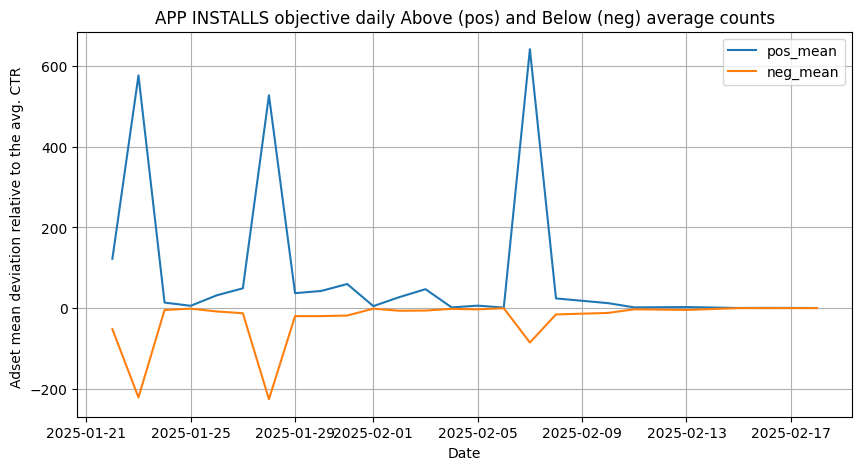

In [114]:
means_df = means_sdf.toPandas()

print(f"Ad set Above and Below performed {_metric_diff.split('_')[1]} performance".upper()+\
      "\nThe y-axis shows adset means grouped by objective, date, and adset id. "+\
      f"the implies metric of pos ad sets are those with {_metric_diff.split('_')[1].upper()} > "+\
      f"daily average {_metric_diff.split('_')[1].upper()} and neg implies are thosse with "+\
      f"{_metric_diff.split('_')[1].upper()} < daily average {_metric_diff.split('_')[1].upper()}.\n")

fig, ax = plt.subplots(1, figsize=(10, 10))

means_df.set_index('date')[['pos_mean', 'neg_mean']]\
        .plot(figsize=(10,5), grid=True, ax=ax)

ax.set_title(f"{_objective.replace('_',' ').upper()} objective daily Above (pos) and Below (neg) average counts")
ax.set_xlabel('Date')
ax.set_ylabel(f"Adset mean deviation relative to the avg. {_metric_diff.split('_')[1].upper()} ")
ax.legend(loc='upper right')

plt.show()

## Above and Below performance spend

In [88]:
_neg_metric = _dev_sdf.filter((F.col(_metric_diff)<0) & 
                              (F.col('objective').isin(_objective)))\
                        .select('spend_mean', _metric_diff)\
                        .toPandas()
_pos_metric = _dev_sdf.filter((F.col(_metric_diff)>0) &
                              (F.col('objective').isin(_objective)))\
                        .select('spend_mean', _metric_diff)\
                        .toPandas()
print("negative metric %d and postive metric %d rows to plot" 
      % (_neg_metric.shape[0], _pos_metric.shape[0]))

[Stage 1031:============>   (4 + 1) / 5][Stage 1033:>               (0 + 0) / 1]

negative metric 220 and postive metric 86 rows to plot


AD SET ABOVE AND BELOW PERFORMED CTR PERFORMANCE
The y-axis shows adset, above and below average, counts for the particular objective. the implies counts of pos ad sets are those with CTR > daily average CTR and neg implies are thosse with CTR < daily average CTR.



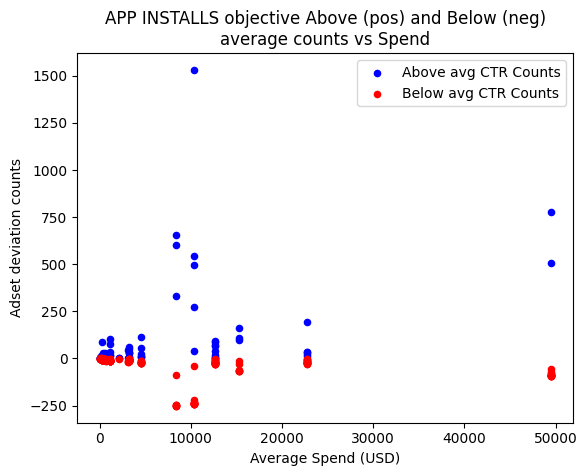

In [115]:
# fig, ax = plt.subplots(1, figsize=(10, 10))
print(f"Ad set Above and Below performed {_metric_diff.split('_')[1]} performance".upper()+\
      "\nThe y-axis shows adset, above and below average, counts for the particular objective. "+\
      f"the implies counts of pos ad sets are those with {_metric_diff.split('_')[1].upper()} > "+\
      f"daily average {_metric_diff.split('_')[1].upper()} and neg implies are thosse with "+\
      f"{_metric_diff.split('_')[1].upper()} < daily average {_metric_diff.split('_')[1].upper()}.\n")

ax = _pos_metric.plot(x='spend_mean', y=_metric_diff, kind='scatter', 
                      color='blue', label=f"Above avg {_metric_diff.split('_')[1].upper()} Counts")
_neg_metric.plot(ax=ax, x='spend_mean', y=_metric_diff, kind='scatter', 
                 color='red', label=f"Below avg {_metric_diff.split('_')[1].upper()} Counts")

ax.set_title(f"{_objective.replace('_',' ').upper()} "+\
             "objective Above (pos) and Below (neg)\naverage counts vs Spend")
ax.set_xlabel('Average Spend (USD)')
ax.set_ylabel('Adset deviation counts')
ax.legend(loc='upper right')

plt.show()